In [2]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import mplfinance
import sys
import numpy as np
from datetime import datetime
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import requests
import io
import mplfinance.original_flavor as mpf
import datetime

dfc               SAR  STATUS
0    20963.000000       1
1    20965.940000       2
2    20960.000000       3
3    21130.000000      -1
4    21160.000000      -2
..            ...     ...
677  20533.946381      18
678  20623.230670      19
679  20705.372217      20
680  20780.942439      21
681  20850.467044      22

[682 rows x 2 columns]
sar_latest 20850.4670442226
status_latest 22
          time  close   open   high    low      Vol           SAR  STATUS
0   2017-12-25  21070  21000  21110  20960  1771527  20963.000000       1
1   2017-12-26  21000  21040  21100  20970  2303834  20965.940000       2
2   2017-12-27  21070  21000  21130  20990  2848641  20960.000000       3
3   2017-12-28  20840  21100  21160  20750  4238365  21130.000000      -1
4   2017-12-29  20820  20940  21030  20770  3475867  21160.000000      -2
..         ...    ...    ...    ...    ...      ...           ...     ...
677 2020-10-12  21340  21370  21380  21240  3774776  20533.946381      18
678 2020-10-13  21390  

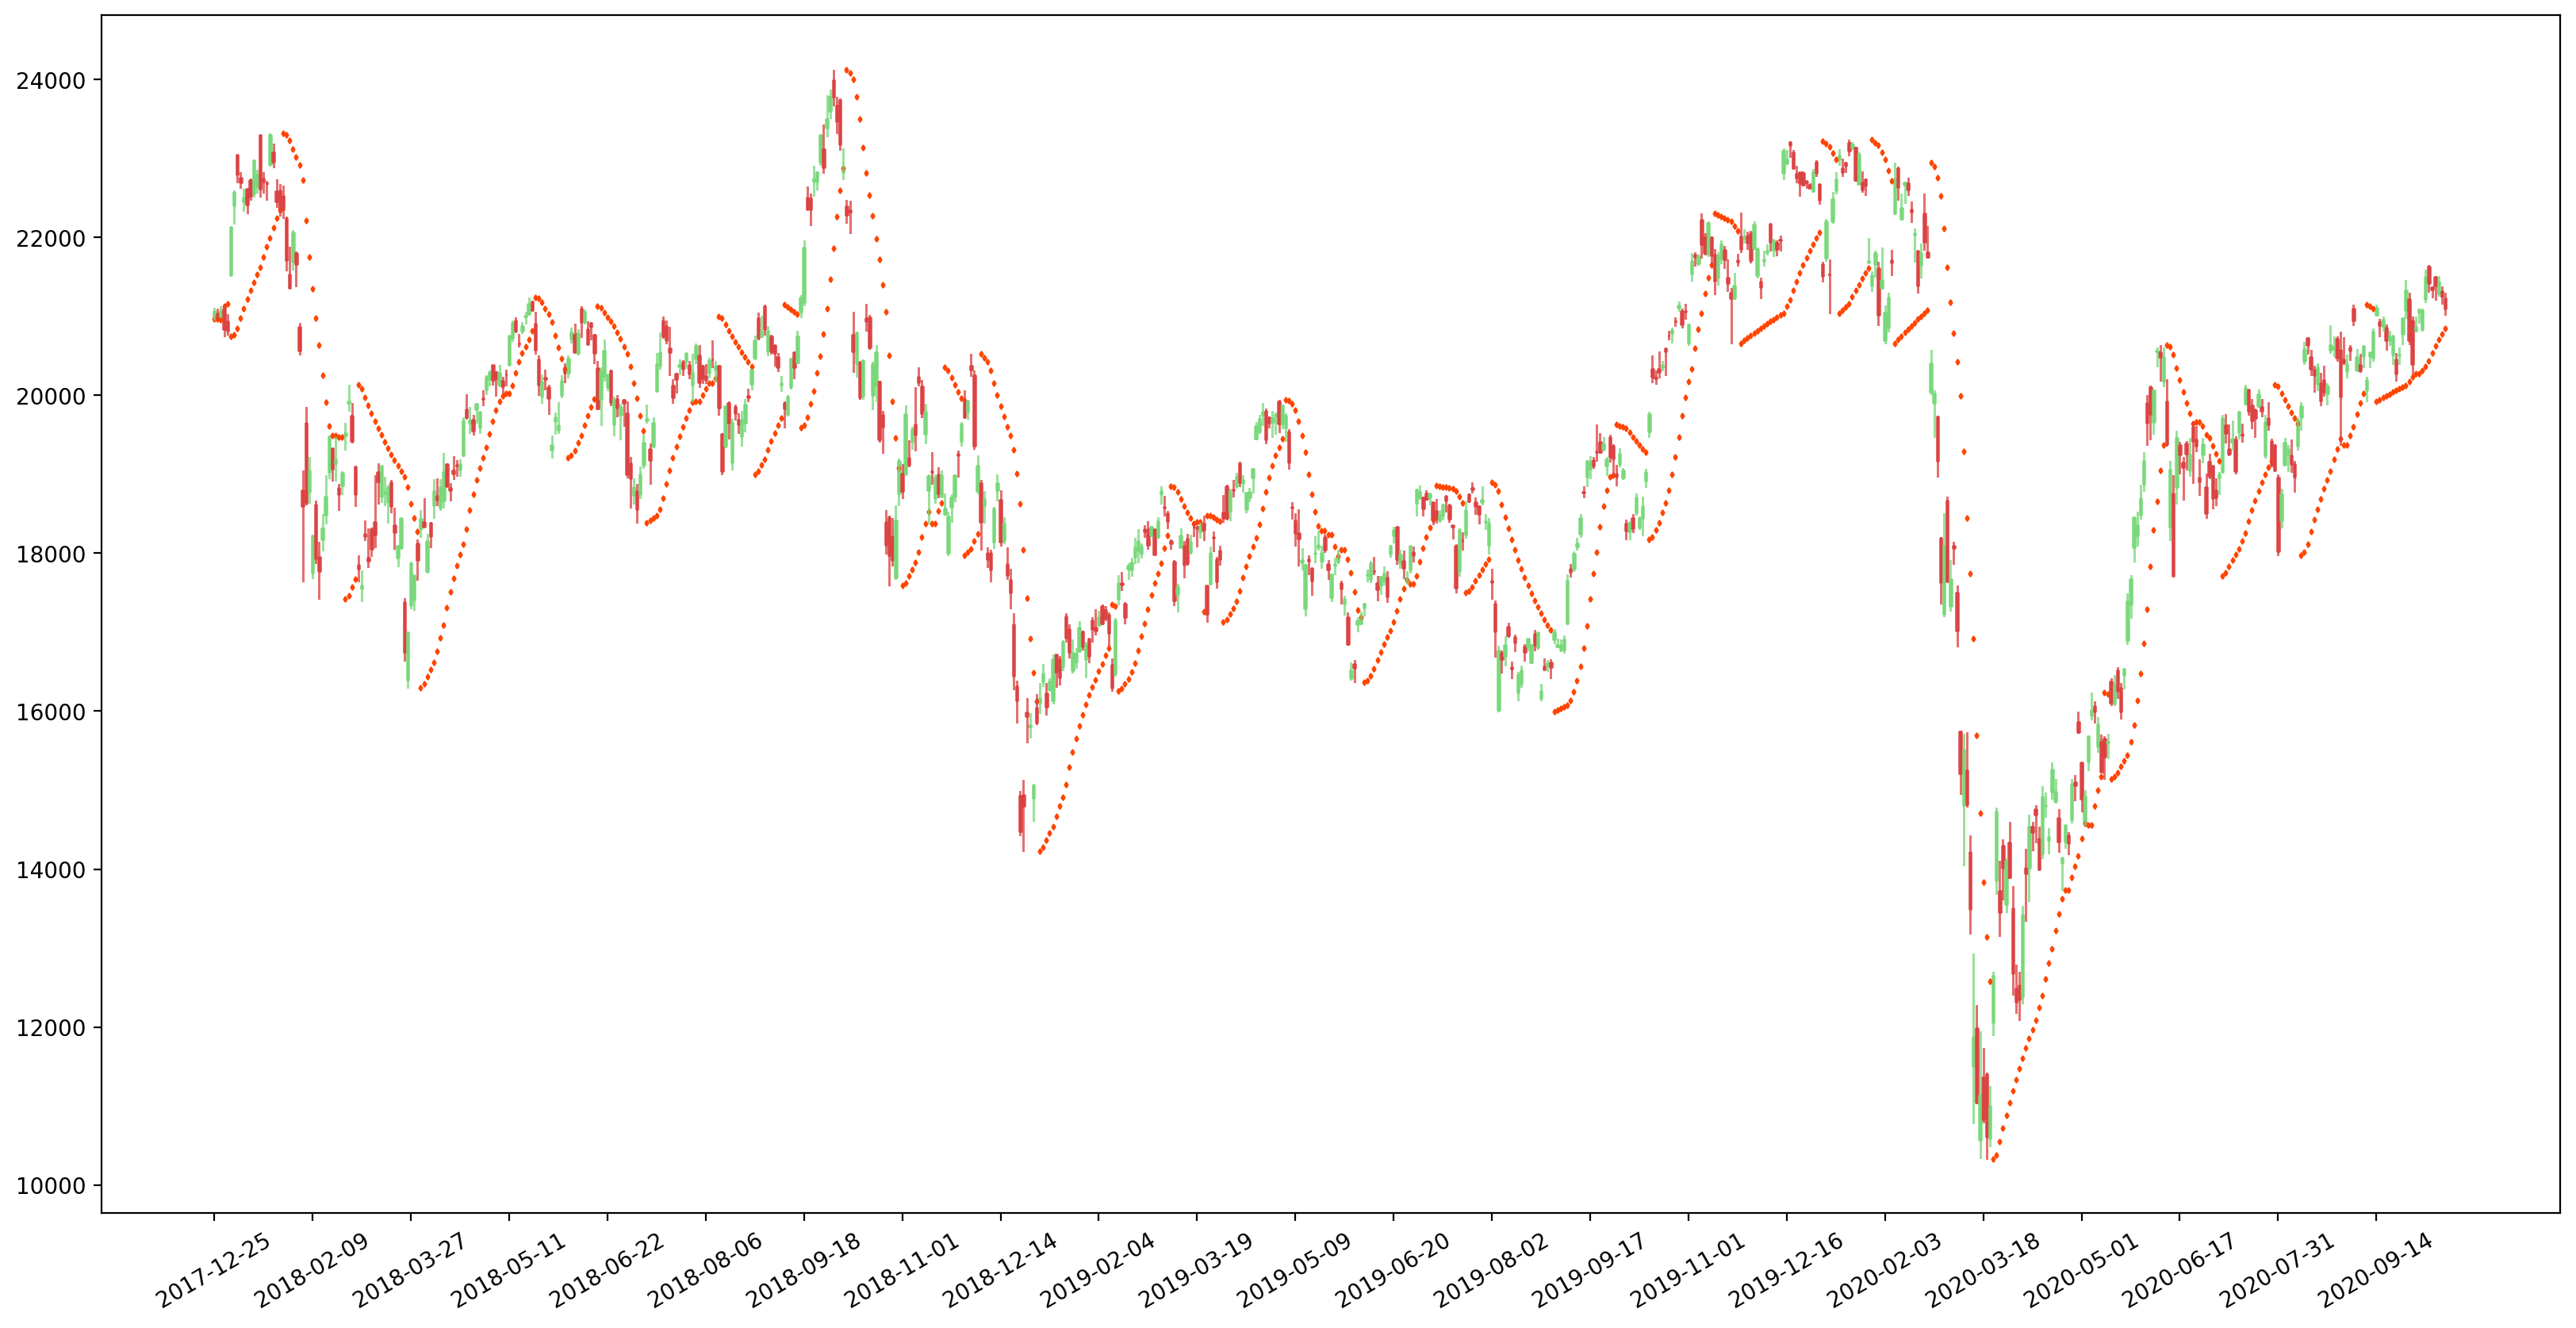

In [6]:
# parabolicSAR生成
# # # # # # # # # # # # # # # # # # # # # # # # # # # #
#                   Parabolic SAR                     #
# # # # # # # # # # # # # # # # # # # # # # # # # # # #
INITIAL_AF = 0.02
MAX_AF = 0.2

def calc_next_parabolic(last_sar, ep, acceleration_f=INITIAL_AF):
    return last_sar + acceleration_f * (ep - last_sar)

def parabolic_is_touched(bull, current_parabo, current_h, current_l):
    

    if bull and (current_parabo > current_l):

        return True
    elif not bull and (current_parabo < current_h):

        return True

    return False

def calc_parabolic(candles):
    # 初期値
    acceleration_factor = INITIAL_AF
    # INFO: 初期状態は上昇トレンドと仮定して計算
    bull = True
    extreme_price = candles.high[0]
    temp_sar_array = [candles.low[0]]
    status=0
    status_array=[]

    # HACK: dataframeのまま処理するより、to_dictで辞書配列化した方が処理が早い
    candles_array = candles.to_dict('records')
    for i, row in enumerate(candles_array):
        current_high = row['high']
        current_low = row['low']
        last_sar = temp_sar_array[-1]

        # レートがparabolicに触れたときの処理
        if parabolic_is_touched(
            bull=bull,
            current_parabo=last_sar,
            current_h=current_high, current_l=current_low
        ):
            #print('touch',i)
            temp_sar = extreme_price
            acceleration_factor = INITIAL_AF
            if bull:
                bull = False
                extreme_price = current_low
                status=0
            else:
                bull = True
                status=0
                extreme_price = current_high
        else:
            # SARの仮決め
            #print('nontouch',i)
            temp_sar = calc_next_parabolic(
                last_sar=last_sar, ep=extreme_price, acceleration_f=acceleration_factor
            )


            # AFの更新
            if (bull and extreme_price < current_high) \
                or not bull and extreme_price > current_low:
                acceleration_factor = min(
                    acceleration_factor + INITIAL_AF,
                    MAX_AF
                )
                

                
            # SARの調整
            if i>1:
                if bull:
                    temp_sar = min(
                        temp_sar, candles_array[i-1]['low'], candles_array[i-2]['low']
                    )

                    extreme_price = max(extreme_price, current_high)
                else:
                    temp_sar = max(
                        temp_sar, candles_array[i-1]['high'], candles_array[i-2]['high']
                    )
                    #print("FALSE",i)
                    extreme_price = min(extreme_price, current_low)

        if i == 0:
            temp_sar_array[-1] = temp_sar
            status=1 if bull==True else -1
            status_array.append(status)
            #print("temp_sar_array[-1]", temp_sar_array[-1])
        else:
            temp_sar_array.append(temp_sar)
            status=status+1 if bull==True else status-1
            status_array.append(status)
            
            
    sar_latest=temp_sar_array[len(temp_sar_array)-1]
    status_latest=status_array[len(status_array)-1]
    df0 = pd.DataFrame(temp_sar_array,columns=["SAR"])
    df1= pd.DataFrame(status_array,columns=["STATUS"])
    dfc=pd.concat([df0, df1],axis=1)
    print("dfc",dfc)
    print("sar_latest",sar_latest)    
    print("status_latest",status_latest)     
    
            
    return dfc


#### (1)パラボリック解析を行う #######

#(1-1) 株価データを読み込む
STOCKNUM=1570 #日経レバ
df= pd.read_csv(str(STOCKNUM) + ".csv",parse_dates=True,index_col=0)
df.reset_index("DATE",inplace=True)  #DATE列のindexを解除する。

#(1-2) データ成形を行う
df= df.rename(columns={'DATE': 'time','CLOSE': 'close', 'OPEN': 'open', 'HIGH': 'high', 'LOW': 'low', 'VOL': 'Vol'})#各列名を所望の列名に変更する。
df=df.reset_index(drop=True)
candles=df.copy()

#(1-3) パラボリック解析を行う
candles=pd.concat([candles, calc_parabolic(candles)],axis=1) 
print(candles)

#### (2)チャート描写する　#######

# チャートの描画
figure, (axis1) = plt.subplots(nrows=1, ncols=1, figsize=(20, 10), dpi=200)
mpf.candlestick2_ohlc(
    axis1,
    opens  = candles.open.values,
    highs  = candles.high.values,
    lows   = candles.low.values,
    closes = candles.close.values,
    width=0.6, colorup='#77d879', colordown='#db3f3f'
)

# SAR描画
for key, column in candles[['SAR']].iteritems():
    axis1.scatter(x=candles[['SAR']].index, y=column.values, label=key, c='orangered', marker='d', s=2)

# グラフの見た目を整形
### X軸の見た目を整える
xticks_number = 30 # 12本(60分)刻みに目盛りを書く
xticks_index = range(0, len(candles), xticks_number)

xticks_display = [pd.to_datetime(candles.time.values[i]).date() for i in xticks_index] # 時間を切り出すため、先頭12文字目から取る
plt.sca(axis1)
plt.xticks(xticks_index, xticks_display, rotation=30)


#plt.xlim(datetime.datetime(2020,1,1), datetime.datetime(2020,1,12)) 
# 画像生成
plt.show()





          time        high         low        open       close        Vol  \
0   2019-07-23  275.500000  273.890015  274.709991  275.489990  1753000.0   
1   2019-07-24  276.790009  274.670013  274.779999  276.760010  1669900.0   
2   2019-07-25  276.410004  274.679993  276.410004  275.410004  1874200.0   
3   2019-07-26  277.549988  276.100006  276.200012  277.380005  1796900.0   
4   2019-07-29  277.269989  276.260010  277.230011  276.880005  2925900.0   
..         ...         ...         ...         ...         ...        ...   
295 2020-09-22  305.239990  300.670013  303.109985  304.739990  2741500.0   
296 2020-09-23  305.549988  297.170013  305.279999  297.679993  2755800.0   
297 2020-09-24  301.459991  295.040009  296.309998  298.500000  3130700.0   
298 2020-09-25  304.040009  296.720001  297.579987  303.279999  2683800.0   
299 2020-09-28  309.019989  306.429993  307.420013  308.359985  2422100.0   

            SAR  
0    273.922214  
1    273.890015  
2    273.890015  
3  

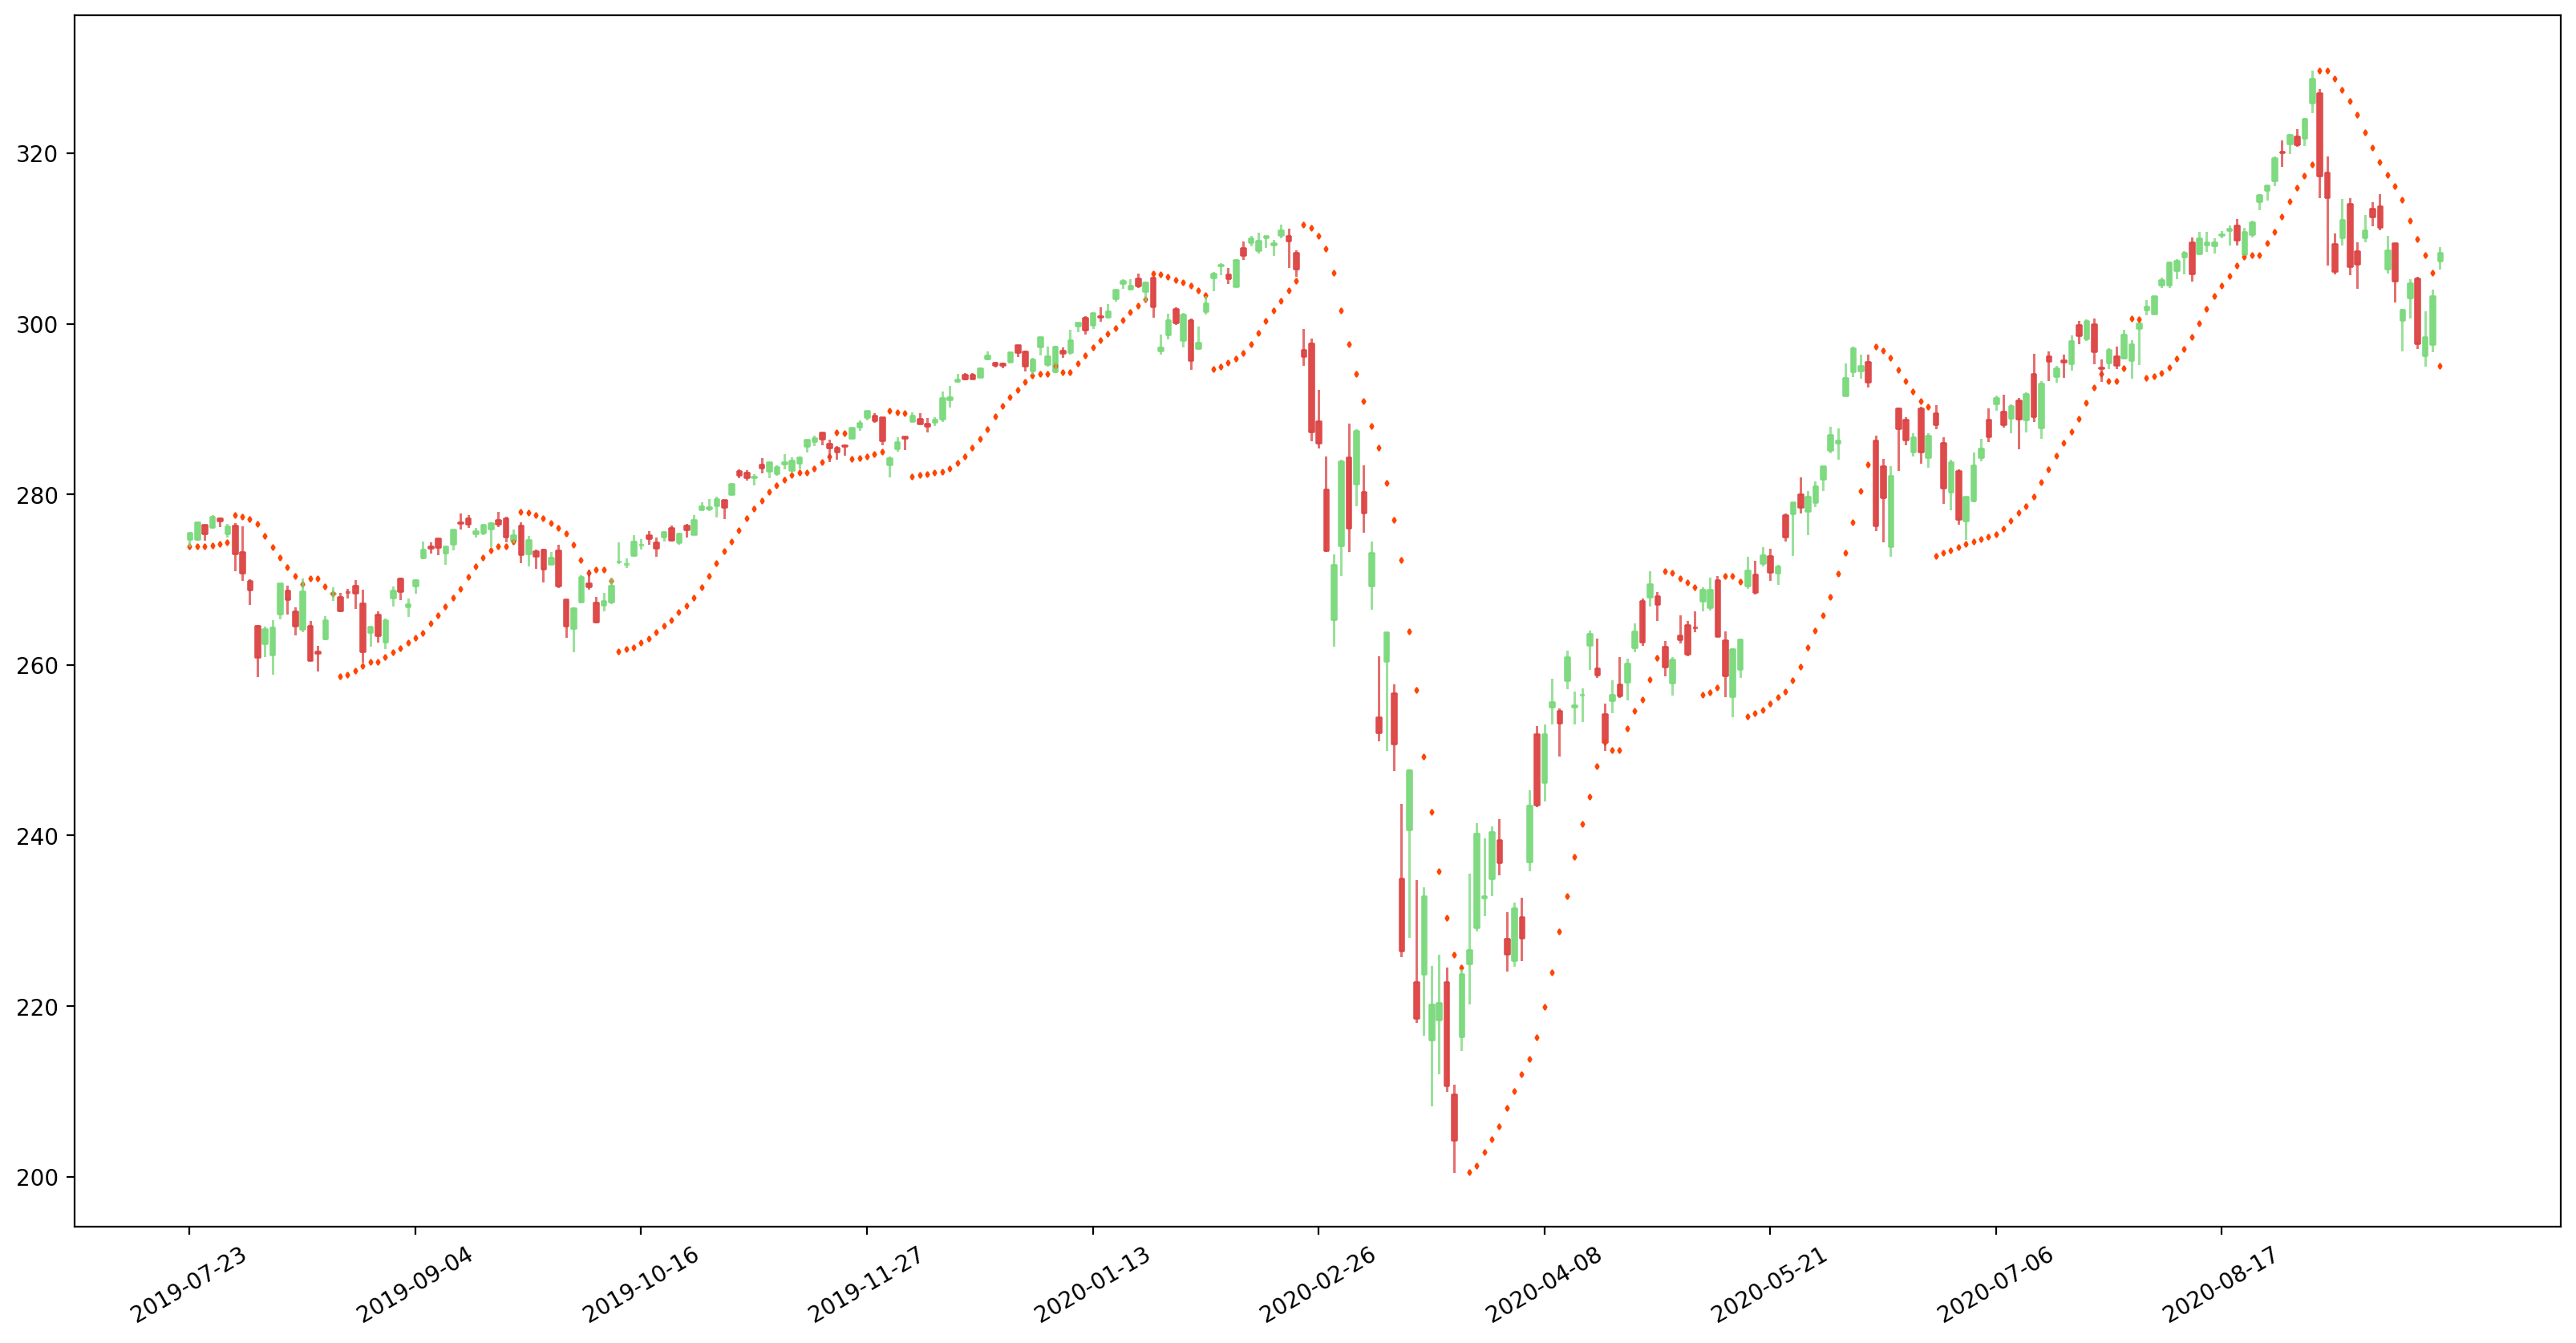

In [18]:
# parabolicSAR生成
# # # # # # # # # # # # # # # # # # # # # # # # # # # #
#                   Parabolic SAR                     #
# # # # # # # # # # # # # # # # # # # # # # # # # # # #
INITIAL_AF = 0.02
MAX_AF = 0.2

def calc_next_parabolic(last_sar, ep, acceleration_f=INITIAL_AF):
    return last_sar + acceleration_f * (ep - last_sar)

def parabolic_is_touched(bull, current_parabo, current_h, current_l):
    if bull and (current_parabo > current_l):
        return True
    elif not bull and (current_parabo < current_h):
        return True
    return False

def calc_parabolic(candles):
    # 初期値
    acceleration_factor = INITIAL_AF
    # INFO: 初期状態は上昇トレンドと仮定して計算
    bull = True
    extreme_price = candles.high[0]
    temp_sar_array = [candles.low[0]]

    # HACK: dataframeのまま処理するより、to_dictで辞書配列化した方が処理が早い
    candles_array = candles.to_dict('records')
    for i, row in enumerate(candles_array):
        current_high = row['high']
        current_low = row['low']
        last_sar = temp_sar_array[-1]

        # レートがparabolicに触れたときの処理
        if parabolic_is_touched(
            bull=bull,
            current_parabo=last_sar,
            current_h=current_high, current_l=current_low
        ):
            temp_sar = extreme_price
            acceleration_factor = INITIAL_AF
            if bull:
                bull = False
                extreme_price = current_low
            else:
                bull = True
                extreme_price = current_high
        else:
            # SARの仮決め
            temp_sar = calc_next_parabolic(
                last_sar=last_sar, ep=extreme_price, acceleration_f=acceleration_factor
            )

            # AFの更新
            if (bull and extreme_price < current_high) \
                or not bull and extreme_price > current_low:
                acceleration_factor = min(
                    acceleration_factor + INITIAL_AF,
                    MAX_AF
                )

            # SARの調整
            if bull:
                temp_sar = min(
                    temp_sar, candles_array[i-1]['low'], candles_array[i-2]['low']
                )
                extreme_price = max(extreme_price, current_high)
            else:
                temp_sar = max(
                    temp_sar, candles_array[i-1]['high'], candles_array[i-2]['high']
                )
                extreme_price = min(extreme_price, current_low)

        if i == 0:
            temp_sar_array[-1] = temp_sar
        else:
            temp_sar_array.append(temp_sar)
    return pd.DataFrame(data=temp_sar_array, columns=['SAR'])


#### (1)パラボリック解析を行う #######

#(1-1) 株価データを読み込む
#STOCKNUM=1570
STOCKNUM='VOO'
df= pd.read_csv("//25.32.185.252/pi/dcshare/techan-vue/static/" + str(STOCKNUM) + ".csv",parse_dates=True,index_col=0)
df.reset_index("DATE",inplace=True)  #DATE列のindexを解除する。

#(1-2) データ成形を行う
df= df.rename(columns={'DATE': 'time','CLOSE': 'close', 'OPEN': 'open', 'HIGH': 'high', 'LOW': 'low', 'VOL': 'Vol'})#各列名を所望の列名に変更する。
df=df.tail(300)
df=df.reset_index(drop=True)
candles=df.copy()

#(1-3) パラボリック解析を行う
candles['SAR'] = calc_parabolic(candles)
print(candles)



#### (2)チャート描写する　#######

# チャートの描画
figure, (axis1) = plt.subplots(nrows=1, ncols=1, figsize=(20, 10), dpi=200)
mpf.candlestick2_ohlc(
    axis1,
    opens  = candles.open.values,
    highs  = candles.high.values,
    lows   = candles.low.values,
    closes = candles.close.values,
    width=0.6, colorup='#77d879', colordown='#db3f3f'
)

# SAR描画
for key, column in candles[['SAR']].iteritems():
    axis1.scatter(x=candles[['SAR']].index, y=column.values, label=key, c='orangered', marker='d', s=2)

# グラフの見た目を整形
### X軸の見た目を整える
xticks_number = 30 # 12本(60分)刻みに目盛りを書く
xticks_index = range(0, len(candles), xticks_number)

xticks_display = [pd.to_datetime(candles.time.values[i]).date() for i in xticks_index] # 時間を切り出すため、先頭12文字目から取る
plt.sca(axis1)
plt.xticks(xticks_index, xticks_display, rotation=30)


#plt.xlim(datetime.datetime(2020,1,1), datetime.datetime(2020,1,12)) 
# 画像生成
plt.show()



In [25]:
candles_array=candles.to_dict('records')
for i, row in enumerate(candles_array):
        #print(i)
        print(row)

{'time': Timestamp('2019-07-23 00:00:00'), 'high': 275.5, 'low': 273.8900146484375, 'open': 274.70999145507807, 'close': 275.489990234375, 'Vol': 1753000.0, 'SAR': 273.9222143554687}
{'time': Timestamp('2019-07-24 00:00:00'), 'high': 276.79000854492193, 'low': 274.67001342773443, 'open': 274.77999877929693, 'close': 276.760009765625, 'Vol': 1669900.0, 'SAR': 273.8900146484375}
{'time': Timestamp('2019-07-25 00:00:00'), 'high': 276.41000366210943, 'low': 274.67999267578125, 'open': 276.41000366210943, 'close': 275.41000366210943, 'Vol': 1874200.0, 'SAR': 273.8900146484375}
{'time': Timestamp('2019-07-26 00:00:00'), 'high': 277.54998779296875, 'low': 276.10000610351557, 'open': 276.20001220703125, 'close': 277.3800048828125, 'Vol': 1796900.0, 'SAR': 274.0060144042969}
{'time': Timestamp('2019-07-29 00:00:00'), 'high': 277.26998901367193, 'low': 276.260009765625, 'open': 277.23001098632807, 'close': 276.8800048828125, 'Vol': 2925900.0, 'SAR': 274.2186528076172}
{'time': Timestamp('2019-07

In [14]:
dat0 = [1,2,3,4,5]
dat1 = [5,4,3,2,1]

df0 = pd.DataFrame(dat0,columns=["A"])
df1= pd.DataFrame(dat1,columns=["B"])
dfc=pd.concat([df0, df1],axis=1)


print(dfc)




   A  B
0  1  5
1  2  4
2  3  3
3  4  2
4  5  1
